fetching:  https://www.ndbc.noaa.gov/data/realtime2/46054.data_spec
data
automated runner.ipynb
SWH.png
swel.png
.ipynb_checkpoints
explore_wave_data.ipynb
scratchpad.ipynb
terse.ipynb
class_scratch.ipynb


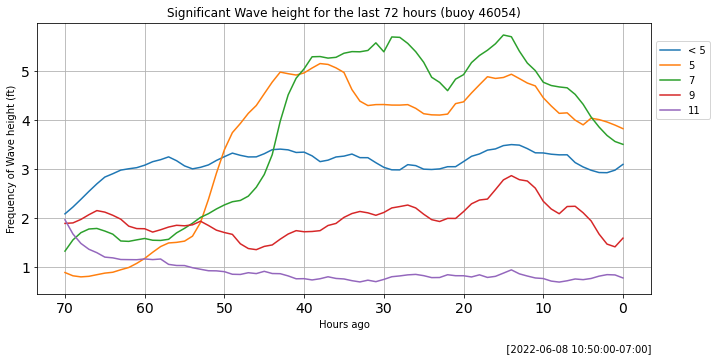

In [21]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import savgol_filter
np.set_printoptions(precision=2)

import requests
import arrow

import os
#absolute_path = os.path.abspath(__file__)
#print("Full path: " + absolute_path)
#print("Directory Path: " + os.path.dirname(absolute_path))

# Define constants
buoy_id = '46054'
hours = 72
periods = [0, 5, 7, 9, 11, 13]
URL = "https://www.ndbc.noaa.gov/data/realtime2/{}.data_spec".format(buoy_id)
date_format = 'YYYY-MM-DD HH:mm'
date_pattern = '{}-{}-{} {}:{}'

# READ data from NOAA into memory
print("fetching: ",URL)
raw_request = requests.get(URL)
raw_data = raw_request.text

# These empty lists become lists of lists (a data matrix)
dates = []
energies = []
frequencies = []
lines = raw_data.split("\n")

# Get the data from the file
for l in lines[:hours]:
    if(len(l) > 100):

        # Parse the date into localized Arrow object
        di = l.split()[0:5]
        datestr = date_pattern.format(di[0],di[1],di[2],di[3],di[4])
        a = arrow.get(datestr, date_format)
        dates.append(a.to('US/Pacific'))

        # Energies are easy to parse: 1st from every other data pair
        energies.append([float(e) for e in l.split()[6::2]])

        # Frequecies are 2nd from every other data pair, without parenthesis
        freqs = l.split()[7::2]
        frequencies.append([float(i[1:-1]) for i in freqs])

# Parse the data
# Create numpy arrays from the arrays
E = np.array(energies)                       # E for 'Energy'
f = np.array(frequencies)                    # f for 'frequency'
df = np.diff(f)

# Pandas experiment
import pandas as pd
pan_E = pd.DataFrame(E, index=dates)
pan_df = pd.DataFrame(df, index=dates)
#----------------------

fmid = .5*(f[:, :-1] + f[:, 1:])              # only used to consider
                                              # frequencies by period bins
Emid = .5*(E[:, :-1] + E[:, 1:])
p = np.array(periods) # arbitrary periods
pmid = .5*(p[1:] + p[:-1])                    # mid-point resolution
Pf = 1./fmid[0, :]                            # convert from freq. to period

# plotting options
fig, ax = plt.subplots()
fig.set_size_inches(11, 5)
fig.savefig('SWH.png', dpi=100)

for idx, _ in enumerate(pmid):               # loop over period mid-point
                                             # indexes
                                             # (to make bins: period and neighbor)

    #TODO seems like we could utilize a pandas data structure
    # to track swf from within this loop
    # then pass make use of the one structure outside of the loop

    #print("pmid[{}] = {}".format(idx,_))
    period_mask = (Pf > p[idx]) & (Pf <= p[idx+1]) # create a boolean mask of which period data will fit in this bin
    df_subset = df[:, period_mask]           # subset of frequency
    Emid_subset = Emid[:, period_mask]       # subset Energy
    variance = (df_subset*Emid_subset)              
    SWH = (4*np.sqrt(variance.sum(axis=1)))  # 4*(sqrt of variance) rerturns the 'crest to trough' wave height
    if idx == 0:                             # creating a legend
        label = '< {}'.format(str(periods[1]))
    else:
        label = p[idx]
    
    signif = SWH[0:hours]* 3.28              # convert meters to feet
    smoothed = savgol_filter(signif, 9, 3)   # apply a Savitzky-Golay filter
    ax.plot(smoothed,label=label)            # add it to the plot 

plt.gca().invert_xaxis()                     # invert the x axis (since it is looking back in time)
#year, month,day, hour, minute = dates[0]
#date = "{0}/{1}/{2} {3}:{4}".format(year,month,day, hour, minute)

ax.set(xlabel='Hours ago', 
       ylabel='Frequency of Wave height (ft)',
       title='Significant Wave height for the last {} hours (buoy {})'.format(hours,buoy_id))
ax.legend(bbox_to_anchor=(1, .95))           # add the legend

ax.tick_params(labelsize = 14)

# Add a footnote below and to the right side of the chart
ax.annotate( "   ["+ dates[0].format()+"]",
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
ax.grid()
plt.savefig("./swel.png")

#dir_list = os.listdir()
#print("Files and directories in '", path, "' :")
#print(dir_list)
obj = os.scandir()
for entry in obj:
  if entry.is_dir() or entry.is_file():
    print(entry.name)


In [8]:
print(dates[0])

2022-06-08T10:50:00-07:00
